In [1]:
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime
import fnmatch
from netCDF4 import Dataset, num2date
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,5)

## ZOS data extraction

## Single Location

In [21]:
# create a empty dataframe to save extracted data
Data=pd.DataFrame()

# coordinate of location in wgs84
latitude=16.475272
longitude=89.361124

# direcotory of input netcdf data
path=r'E:\MYS\Ocean Variables\Model\*\*\*\*.nc'

for file in os.listdir(path):
    if (fnmatch.fnmatch(file, '*zos_*.nc')) and (file[-3:]=='.nc'):
        ncfile=Dataset(path+'\\'+file)
        
        ensemble=getattr(ncfile,'parent_experiment_rip')
        model=getattr(ncfile, 'model_id')
        projection=getattr(ncfile, 'experiment_id')
        
        lat=ncfile.variables['lat'][:,:]
        lon=ncfile.variables['lon'][:,:]
        times=ncfile.variables['time']
        
        dates=num2date(times[:], times.units, calendar=times.calendar)
        
        
        a = abs(lat-latitude)+abs(lon-longitude)
        j,i = np.unravel_index(a.argmin(),a.shape)
        
        zos=ncfile.variables['zos'][:,j,i].data
        df=pd.DataFrame({'model':model,'projection':projection,'ensemble':ensemble,'date':dates,'Sea Surface Height Above Geoid (m)':zos})
        Data=Data.append(df)

        print('processing is done:', file)
         

processing is done: zos_Omon_ACCESS1-0_rcp45_r1i1p1_200601-210012.nc
processing is done: zos_Omon_ACCESS1-0_rcp85_r1i1p1_200601-210012.nc


## Multiple Locations

In [ ]:
# direcotory of input netcdf data
path=r'E:\MYS\Ocean Variables\Model\*\*\*\*.nc'
# coordinates of geographic locations in wgs84
location=pd.read_excel('Location.xlsx')

for index, row in location.iterrows():
    point=row['location']
    latitude=row['latitude']
    longitude=row['longitude']
    
    Data=pd.DataFrame()
    
    for file in glob.glob(path):
        if (fnmatch.fnmatch(file, '*zos_*.nc')) and (file[-3:]=='.nc'):
            
            ncfile=Dataset(file,'r')
        
            ensemble=getattr(ncfile,'parent_experiment_rip')
            model=getattr(ncfile, 'model_id')
            projection=getattr(ncfile, 'experiment_id')
            
            dim=ncfile.variables['zos'].dimensions
            
            if dim[1]=='j':
                lat=ncfile.variables['lat'][:,:]
                lon=ncfile.variables['lon'][:,:]
                times=ncfile.variables['time']
                dates=num2date(times[:], times.units, calendar=times.calendar)
                a = abs(lat-latitude)+abs(lon-longitude)
                j,i = np.unravel_index(a.argmin(),a.shape)
                zos=ncfile.variables['zos'][:,j,i].data
                df=pd.DataFrame({'model':model,'projection':projection,'ensemble':ensemble,'date':dates,'Sea Surface Height Above Geoid (m)':zos})
                Data=Data.append(df)
                
            elif dim[1]=='lat':
                nc_lat = ncfile.variables['lat'][:]
                nc_lon = ncfile.variables['lon'][:]
                lat_cell = np.argmin(np.abs(nc_lat - latitude))
                lon_cell = np.argmin(np.abs(nc_lon - longitude))
                times=ncfile.variables['time']
                dates=num2date(times[:], times.units, calendar=times.calendar)
                zos=ncfile.variables['zos'][:,lat_cell,lon_cell].data
                df=pd.DataFrame({'model':model,'projection':projection,'ensemble':ensemble,'date':dates,'Sea Surface Height Above Geoid (m)':zos})
                Data=Data.append(df)
                
            elif dim[1]=='rlat':
                nc_lat = ncfile.variables['rlat'][:]
                nc_lon = ncfile.variables['rlon'][:]
                lat_cell = np.argmin(np.abs(nc_lat - latitude))
                lon_cell = np.argmin(np.abs(nc_lon - longitude))
                times=ncfile.variables['time']
                dates=num2date(times[:], times.units, calendar=times.calendar)
                zos=ncfile.variables['zos'][:,lat_cell,lon_cell].data
                df=pd.DataFrame({'model':model,'projection':projection,'ensemble':ensemble,'date':dates,'Sea Surface Height Above Geoid (m)':zos})
                Data=Data.append(df)
                
            else:
                pass
            
            ncfile.close()
    
    # save extracted data for each location
    Data.to_excel(str(point)+'.xlsx',index=None)

    print('processing is done:', point)
    

## ZOSTOGA data extraction

In [41]:
# create empty dataframe to save extracted data
Data2=pd.DataFrame()

# direcotory of input netcdf data
path=r'E:\MYS\Ocean Variables\Model\ACCESS1-0'

for file in os.listdir(path):
    if (fnmatch.fnmatch(file, '*zostoga_*.nc')) and (file[-3:]=='.nc'):
        ncfile=Dataset(path+'\\'+file)
        
        ensemble=getattr(ncfile,'parent_experiment_rip')
        model=getattr(ncfile, 'model_id')
        projection=getattr(ncfile, 'experiment_id')
        
        times=ncfile.variables['time']
        
        dates=num2date(times[:], times.units, calendar=times.calendar)
        
        zostoga=ncfile.variables['zostoga'][:].data
        df=pd.DataFrame({'model':model,'projection':projection,'ensemble':ensemble,'date':dates,'Global Average Thermosteric Sea Level Change (m)':zostoga})
        Data2=Data2.append(df)

        print('processing is done:', file)


processing is done: zostoga_Omon_ACCESS1-0_rcp45_r1i1p1_200601-210012.nc
processing is done: zostoga_Omon_ACCESS1-0_rcp85_r1i1p1_200601-210012.nc


## Convert String to Datetime

In [43]:
Data['date']=Data['date'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S'))
Data2['date']=Data2['date'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S'))

## Plotting ZOS Data

Text(0, 0.5, 'Sea Surface Height Above Geoid (m)')

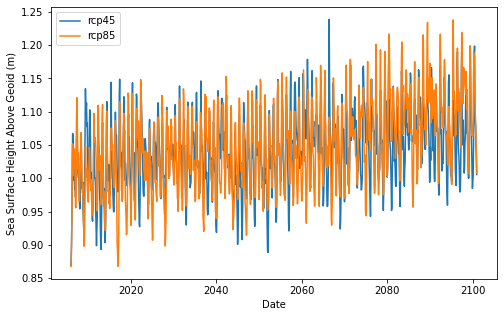

In [48]:
fig, ax=plt.subplots()
for df, df_g in Data.groupby(['model','projection','ensemble']):
    ax.plot(df_g['date'],df_g['Sea Surface Height Above Geoid (m)'],label=df[1])
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sea Surface Height Above Geoid (m)')

## Plotting ZOSTOGA Data

Text(0, 0.5, 'Global Average Thermosteric Sea Level Change (m)')

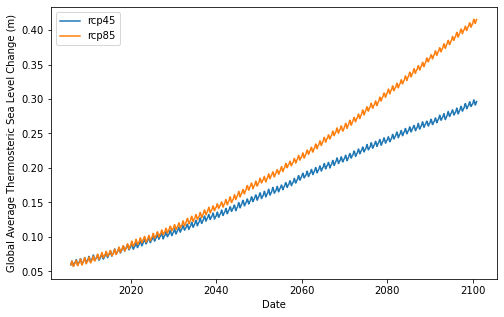

In [49]:
fig, ax=plt.subplots()
for df, df_g in Data2.groupby(['model','projection','ensemble']):
    ax.plot(df_g['date'],df_g['Global Average Thermosteric Sea Level Change (m)'],label=df[1])
plt.legend()
plt.xlabel('Date')
plt.ylabel('Global Average Thermosteric Sea Level Change (m)')

In [53]:
Data

,model,projection,ensemble,date,Sea Surface Height Above Geoid (m)
0,ACCESS1-0,rcp45,r1i1p1,2006-01-16 12:00:00,0.868531
1,ACCESS1-0,rcp45,r1i1p1,2006-02-15 00:00:00,0.881619
2,ACCESS1-0,rcp45,r1i1p1,2006-03-16 12:00:00,0.904598
3,ACCESS1-0,rcp45,r1i1p1,2006-04-16 00:00:00,0.941533
4,ACCESS1-0,rcp45,r1i1p1,2006-05-16 12:00:00,1.010186
...,...,...,...,...,...
1135,ACCESS1-0,rcp85,r1i1p1,2100-08-16 12:00:00,1.096889
1136,ACCESS1-0,rcp85,r1i1p1,2100-09-16 00:00:00,1.086483
1137,ACCESS1-0,rcp85,r1i1p1,2100-10-16 12:00:00,1.057477
1138,ACCESS1-0,rcp85,r1i1p1,2100-11-16 00:00:00,1.035449


In [54]:
Data2

,model,projection,ensemble,date,Global Average Thermosteric Sea Level Change (m)
0,ACCESS1-0,rcp45,r1i1p1,2006-01-16 12:00:00,0.059496
1,ACCESS1-0,rcp45,r1i1p1,2006-02-15 00:00:00,0.061230
2,ACCESS1-0,rcp45,r1i1p1,2006-03-16 12:00:00,0.063567
3,ACCESS1-0,rcp45,r1i1p1,2006-04-16 00:00:00,0.064924
4,ACCESS1-0,rcp45,r1i1p1,2006-05-16 12:00:00,0.064171
...,...,...,...,...,...
1135,ACCESS1-0,rcp85,r1i1p1,2100-08-16 12:00:00,0.409730
1136,ACCESS1-0,rcp85,r1i1p1,2100-09-16 00:00:00,0.410878
1137,ACCESS1-0,rcp85,r1i1p1,2100-10-16 12:00:00,0.412873
1138,ACCESS1-0,rcp85,r1i1p1,2100-11-16 00:00:00,0.414846


In [55]:
Data.to_excel('Sea Surface Height above Geoid.xlsx')
Data2.to_excel('Global Average Thermosteric Sea Level Change.xlsx')